*卷积神经网络(convolutional neural network, convent)，它是计算机视觉应用几乎都在使用的一种深度学习模型*

## 5.1 卷积神经网络简介

In [14]:
# 实例化一个小型的卷积神经网络

#1、加载MNIST数据集
from keras.datasets import mnist
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

#2、数据的预处理
train_data = train_data.reshape((60000, 28, 28, 1))
train_data = train_data.astype('float32') / 255

test_data = test_data.reshape((10000, 28, 28, 1))
test_data = test_data.astype('float32') / 255

#3、标签的预处理
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

#5、构建卷积神经网络
from keras import models, layers
network = models.Sequential()
#卷积神经网络接受形状为(image_height, image_width, image_channels)
network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) 
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Conv2D(64, (3, 3), activation='relu'))

#6、在神经网络上添加分类器
network.add(layers.Flatten()) #将3D输出展平为1D
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

#7、绘制网络模型
from tensorflow.keras.utils import plot_model

plot_model(network, show_shapes = True, to_file = '手写辨识CNN.png')
#查看网络中的参数
network.summary()

#8、编译网络
network.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

#9、训练网络
network.fit(train_data, train_labels, epochs=5, batch_size=64)

#10、在测试集上进行评估
test_loss, test_acc = network.evaluate(test_data, test_labels)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_7 (Flatten)         (None, 576)              

和之前使用两个隐藏层的神经网络相比
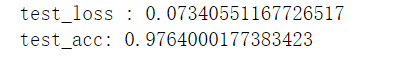

### 5.1.1 卷积运算
#### 密集连接层和卷积层的根本区别在于：Dense层从输入特征空间中学到的是全局模式（比如对MNIST数字，全局模式就是涉及到所有像素的模式），而卷积层学到的是局部模式（对于图像来说，学到的就是在输入图像的二维小窗口中发现的模式）
这个重要特性使卷积神经网络具有以下两个有趣的性质：  
* 卷积神经学到的模式具有平移不变性(translation invariant)。卷积神经网络在图像的某个位置学到模式之后，他可以在任何地方识别这个模式。对于密集连接神经网络而言，如果模式出现在新的位置，他只能重新学习这个模式。这使得卷积神经网络在处理图像时，可以高效的处理数据，他只需要更少的的训练样本就可以学到具有泛化能力的数据表示  
* 卷积神经网络可以学到模式的空间层次结构(spatial hierarchies of pattern)。第一个卷积层将学习较小的局部模式，第二个卷积层将学习由第一层特征组成的更大的模式，以此类推。使得卷积神经网络可以有效地学习越来越复杂、越来越抽象的视觉概念
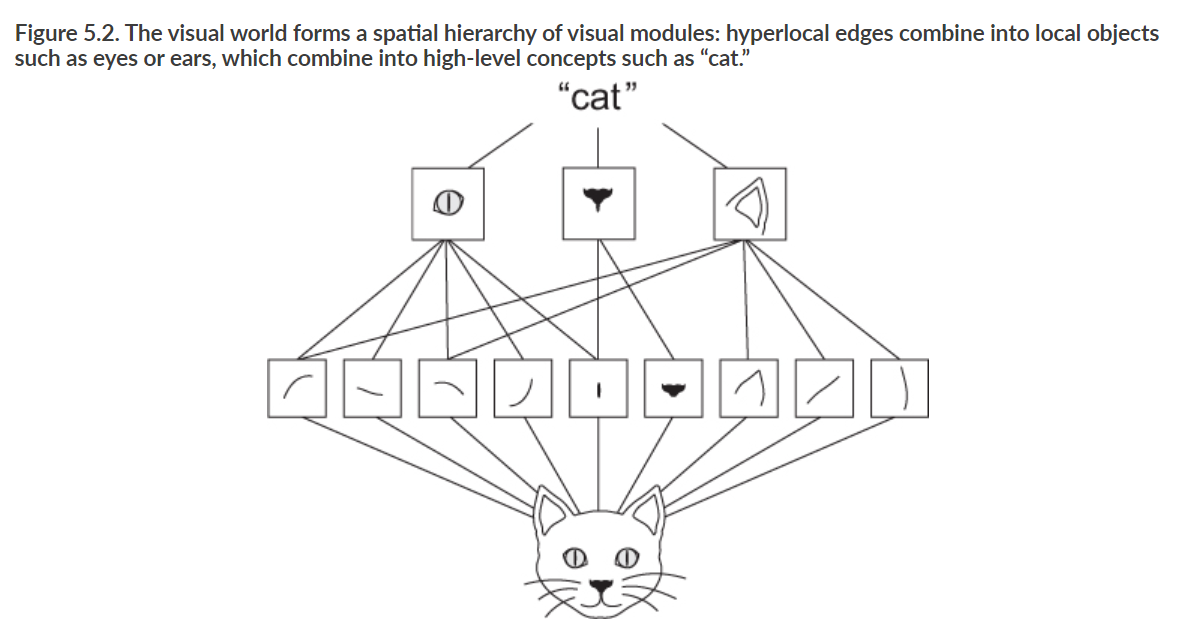

* 对于包含两个空间轴（高度和宽度）和一个深度轴（也叫通道轴）的3D张量，其卷积也叫特征图(feature map)。  
* 对于RGB图像而言，其深度轴的维度大小为3，黑白图像的深度轴的维度大小为1。  
* 卷积运算从特征图中提取图块，并对所有这些图块应用相同的变换，生成输出特征图(output feature map)。该输出特征图仍是一个3D张量，具有高度和宽度，其深度可以是任意值，因为输出的深度是层的参数，深度轴的不同通道不再像RGB输入那样代表特定颜色，而是代表过滤器(filter)。过滤器对输入数据的某一方面进行编码。
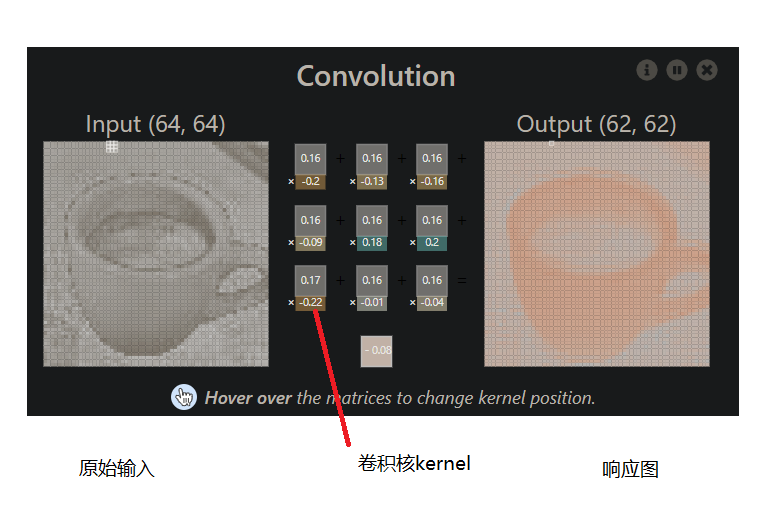

在MNIST示例中，第一个卷积层接受一个大小为(28, 28, 1)的特征图，并输出一个(26, 26, 32)的特征图，即它在输入上计算32个过滤器。对于这32个输出通道，每个通道都包含一个26 * 26的数值网格，它是过滤器对输入的响应图，表示这个过滤器在不同位置上的响应。  
* 响应图，定量描述这个过滤器模式在不同位置中是否存在  
* 特征图：深度轴的每一个维度都是一个特征。而2D张量output[:, :, n]是这个过滤器在输入上相应的二维空间图(map)。
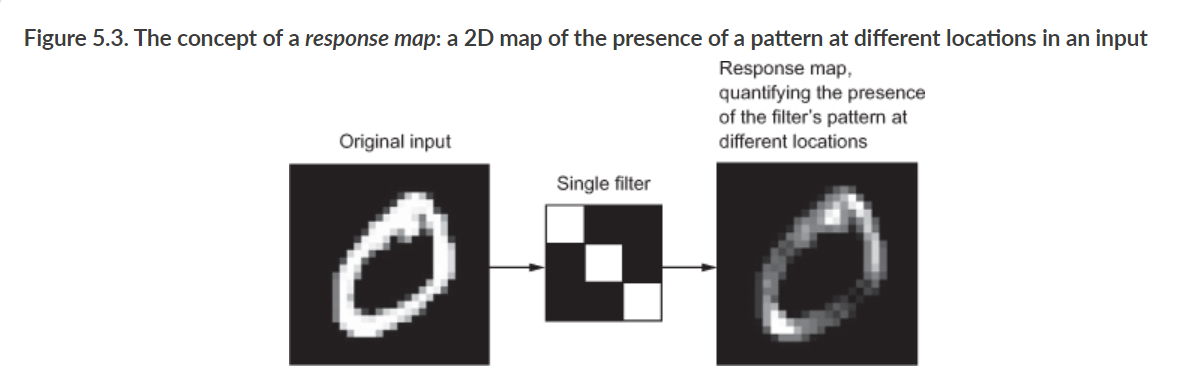

卷积由以下两个关键参数定义：
* (1) 从输入中提取的图块尺寸：这些图块尺寸一般是(3, 3)和(5, 5)  
* (2) 输出特征图的深度：卷积所计算的过滤器的数量  
Conv2D(output_depth, window_height, window_width)  
network.add(layers.Dense(卷积核的数量, (卷积核的大小), activation = '激活函数', input_shape = (image_width, image_height, image_channels)))

卷积的工作原理：在3D输入特征图上滑动这些3 * 3或5 * 5的窗口，在每个可能的位置上停止并提取周围特征的3D图块[形状为(window_height, window_width, output_depth)]。  
然后在每个3D图块与学到的同一个权重矩阵[叫做卷积基(convolution kernel)]做张量积转换成形状为(output_depth, )的1D张量。  
再对这些向量进行空间重组，使其转换为形状为(height, width, output_depth)的3D输出特征图。输出特征图中的每个空间位置都对应每个输入特征图中的相同位置。 

CNN解释器https://poloclub.github.io/cnn-explainer/

* 1、边界效应和填充padding:   
    "valid"表示不使用填充，只使用有效的窗口。   
    "same"，表示填充后输出的宽度和高度与输入一致  
* 2、卷积步幅(stride)

### 5.1.2 最大池化运算
最大池化是从输入特征图中提取窗口，并输出每个通道的最大值。  
#### 在不同的CNN架构中，池化层的类型很多，但它们的目的都是逐渐减小网络的空间范围，从而减少网络的参数和整体计算量。  

In [4]:
#如果只使用卷积层，不使用池化层
from keras import models, layers

model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

#查看网络中的参数
model_no_max_pool.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


使用卷积层和池化层的目的是，从图像中提取特征，为了减少特征图的大小